# ライブラリ

まず、必要なライブラリをインポートします。PyTorchのデータ処理にはtorch, torchvision, PILなどが使用されます。


In [ ]:
import os  # ファイルやディレクトリの操作のための標準ライブラリ
import numpy as np  # 数値計算ライブラリ
import matplotlib.pyplot as plt  # グラフや画像を描画するためのライブラリ
import pandas as pd  # データ操作やデータフレームを扱うためのライブラリ
import torch  # PyTorchの基本機能を使用するためのライブラリ（テンソル操作やモデル構築に使用）
import torch.nn as nn  # PyTorchのニューラルネットワークモジュール
import torch.optim as optim  # 最適化アルゴリズム（例: SGD, Adam）を提供するモジュール
from torch.utils.data import Dataset, DataLoader  # カスタムデータセットクラスとバッチ処理のためのデータローダーを提供
from PIL import Image  # 画像処理のためのPillowライブラリ
from torchvision import transforms  # 画像の前処理（トランスフォーム）を行うためのモジュール
from tqdm import tqdm  # 進捗バーを表示するためのライブラリ（長時間処理の進捗を確認）
import random  # データのシャッフルやランダム操作を行うためのライブラリ
from sklearn.metrics import ConfusionMatrixDisplay  # 混同行列を可視化するためのツール
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve # 評価指標を計算する関数
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
#from torchvision.models import resnet50, ResNet50_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





## 準備

In [92]:
def set_seed(seed = 1234):
    '''全体の処理で同じ結果が得られるように、乱数シードを固定します。
    再現性を確保するための設定です。'''
    # NumPyの乱数シードを固定
    np.random.seed(seed)
    # Pythonの標準ライブラリrandomの乱数シードを固定
    random.seed(seed)
    # PyTorchの乱数シードを固定
    torch.manual_seed(seed)
    # PyTorchでGPUを使用する際の乱数シードを固定
    torch.cuda.manual_seed(seed)
    # CuDNNバックエンドを使用する際に、結果が再現できるようにする設定
    torch.backends.cudnn.deterministic = True
    # Pythonのハッシュシードを固定（環境変数で指定）
    os.environ['PYTHONHASHSEED'] = str(seed)

# Seed
set_seed()

# データセット

In [93]:
# データセットのディレクトリを定義
train_dir = r"D:\puresotu\workespace\nakayama_ken-main\nakayama_ken-main\nakayamaken\BreastCancer\train"
val_dir = r"D:\puresotu\workespace\nakayama_ken-main\nakayama_ken-main\nakayamaken\BreastCancer\valid"
test_dir = r"D:\puresotu\workespace\nakayama_ken-main\nakayama_ken-main\nakayamaken\BreastCancer\test"

# クラスラベルを定義（ここでは「0」と「1」の2クラス）
classes = ["0", "1"]

# 前処理

## 画像の前処理（トランスフォーム）の定義

画像に対する前処理（リサイズ、正規化、データ拡張など）を定義します。<br/>
訓練データと検証・テストデータで異なるトランスフォームを適用します。

In [94]:
# 訓練データ用の画像変換（データ拡張を含む）
train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),  # 画像を224x224ピクセルにリサイズ
    transforms.RandomHorizontalFlip(),  # ランダムに水平反転（データ拡張）
    transforms.RandomHorizontalFlip(p=0.5),  # 左右反転（データ拡張）
    transforms.RandomVerticalFlip(p=0.5),    # 上下反転（データ拡張）
    transforms.RandomRotation(90),           # ±90° 回転（データ拡張）
    transforms.ToTensor(),  # 画像をPyTorchのテンソルに変換
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 画像の正規化（平均）
                         std=[0.229, 0.224, 0.225])   # 画像の正規化（標準偏差）
])

# 検証データおよびテストデータ用の画像変換（データ拡張なし）
val_test_transforms = transforms.Compose([
    transforms.Resize((300, 300)),  # 画像を224x224ピクセルにリサイズ
    transforms.ToTensor(),  # 画像をPyTorchのテンソルに変換
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 画像の正規化（平均）
                         std=[0.229, 0.224, 0.225])   # 画像の正規化（標準偏差）
])


## カスタムデータセットクラスの定義

PyTorchでは、Datasetクラスを継承してカスタムデータセットを定義します。<br/>
これにより、画像の読み込みや前処理を柔軟に行うことができます。

In [95]:
class BreastCancerDataset(Dataset):
    """
    カスタムデータセットクラス。
    指定されたディレクトリ内の画像を読み込み、ラベルとともに提供します。
    """
    def __init__(self, root_dir, classes, transform=None):
        """
        データセットの初期化
        :param root_dir: データセットのルートディレクトリ（train, valid, test）
        :param classes: クラスラベルのリスト
        :param transform: 画像に適用する変換（前処理）
        """
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.data = []  # 画像パスとラベルのリストを格納するリスト
        self._prepare_data()  # データの準備を実行

    def _prepare_data(self):
        """
        データセット内の全画像ファイルを読み込み、画像パスとラベルのペアをself.dataに追加します。
        """
        for class_label in self.classes:
            class_path = os.path.join(self.root_dir, class_label)  # クラスごとのディレクトリパスを作成
            label_index = self.classes.index(class_label)  # クラスラベルをインデックスに変換
            if not os.path.isdir(class_path):
                print(f"Warning: {class_path} はディレクトリではありません。")  # ディレクトリが存在しない場合の警告
                continue  # 次のクラスへスキップ
            # クラス内の全画像ファイルをループ
            for img_file in tqdm(os.listdir(class_path), desc=f'Loading {class_label}'):
                img_full_path = os.path.join(class_path, img_file)  # 画像ファイルのフルパスを作成
                # 画像ファイルかどうかを確認（拡張子でフィルタリング）
                if os.path.isfile(img_full_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append((img_full_path, label_index))  # 画像パスとラベルをリストに追加

    def __len__(self):
        """
        データセットのサイズを返します。
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        指定されたインデックスの画像とラベルを返します。
        :param idx: データセット内のインデックス
        :return: (画像テンソル, ラベル) のタプル
        """
        img_path, label = self.data[idx]  # データリストから画像パスとラベルを取得
        try:
            image = Image.open(img_path).convert('RGB')  # 画像を開き、RGBに変換（3チャンネルに）
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")  # 画像の読み込みエラーを表示
            # エラーが発生した場合は黒い画像を作成（代替として）
            image = Image.new('RGB', (224, 224))
        
        if self.transform:
            image = self.transform(image)  # 定義された変換を画像に適用
        return image, label  # 画像テンソルとラベルを返す


## データセットの作成

定義したカスタムデータセットクラスを使用して、訓練、検証、テスト用のデータセットを作成します。

In [96]:
# 訓練、検証、テスト用のデータセットを作成
train_dataset = BreastCancerDataset(root_dir=train_dir, classes=classes, transform=train_transforms)
val_dataset = BreastCancerDataset(root_dir=val_dir, classes=classes, transform=val_test_transforms)

Loading 1: 100%|██████████| 227/227 [00:00<00:00, 23638.98it/s]


## データローダーの作成

データローダーを作成します。<br/>
DataLoaderはデータセットからバッチを生成し、シャッフルや並列データ読み込みをサポートします。

In [97]:
# データローダーの設定
batch_size = 32  # 一度に処理するサンプル数
num_workers = 0  # データ読み込みに使用するサブプロセスの数（マシンのコア数に応じて調整）

# 訓練データ用のデータローダー（シャッフル有り）
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# 検証データ用のデータローダー（シャッフル無し）
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 動作確認

データローダーが正しく動作しているかを確認するために、最初のバッチを表示します。

In [98]:
# データローダーが正しく動作しているか確認するために、最初のバッチを表示
for images, labels in train_loader:
    print(f"Image batch dimensions: {images.shape}")  # 画像のバッチサイズ（例: [64, 3, 224, 224]）
    print(f"Label batch dimensions: {labels.shape}")  # ラベルのバッチサイズ（例: [64]）
    break  # 最初のバッチのみを表示してループを抜ける


Image batch dimensions: torch.Size([32, 3, 300, 300])
Label batch dimensions: torch.Size([32])


# モデルの作成

**畳み込みニューラルネットワーク（Convolutional Neural Network, CNN）**<br/>
畳み込みニューラルネットワーク（CNN）は、主に画像や動画といった視覚データを処理・分析するために設計されたディープラーニングモデルの一種です。<br/>
画像分類や物体検出、認識などのタスクで特に高い性能を発揮します。CNNは、シンプルなエッジ（輪郭）から複雑なパターンまで、空間的な特徴を自動的かつ適応的に学習する構造を持っています。

**CNNの主な構成要素**
1. 畳み込み層（Convolutional Layers）<br/>
画像に対してフィルタ（カーネル）を適用し、エッジやテクスチャ、色といった局所的なパターンを抽出します。各フィルタは特徴マップ（Feature Map）を生成し、画像内の特定のパターンを強調します。

2. プーリング層（Pooling Layers）<br/>
特徴マップの空間的なサイズを縮小し、重要な情報だけを残します。この処理により、ネットワークの効率が向上し、過学習を防ぎつつ、データの重要な部分に集中することができます。

3. 全結合層（Fully Connected Layers, Dense Layers）<br/>
畳み込み層とプーリング層で得られた特徴を1次元のベクトルに変換し、全結合層を通じて分類や予測を行います。これにより、特徴の複雑な組み合わせを学習します。

4. 活性化関数（Activation Functions）<br/>
ReLU（Rectified Linear Unit）などの活性化関数を使用して非線形性を加え、ネットワークが複雑なパターンを学習できるようにします。

5. ドロップアウト（Dropout）<br/>
過学習を防ぐため、訓練時にランダムに一部の入力ユニットを無効化（ゼロ化）します。



**CNNの動作原理**<br/>
CNNは画像をスキャンするようにフィルタをスライドさせてパターンを検出します。<br/>
訓練を通じて、これらのフィルタは特定の視覚的特徴（初期層ではエッジ、深層では抽象的な概念）を認識できるように学習します。<br/>
最後の層でこれらの特徴を組み合わせて予測を行うため、CNNは視覚データや空間データのタスクで非常に高い精度を発揮します。

このニューラルネットワークモデルは、2クラス分類（バイナリ分類）を目的とした畳み込みニューラルネットワーク（CNN）です。

**入力層**

```python
Conv2D(100, (3, 3), activation="relu", input_shape=(224, 224, 3))
```
入力形式：モデルは、224×224ピクセル、RGB（3チャンネル）の画像を入力として受け取ります。<br/>
最初の畳み込み層：100個のフィルタを持ち、フィルタサイズは3×3です。<br/>
ReLU活性化関数を使用して、エッジやテクスチャなどの特徴を画像から抽出します。<br/>

**畳み込み層とプーリング層**

```python
MaxPool2d(kernel_size=2, stride=2) 
```
2×2のフィルタで最大プーリングを行い、特徴マップの空間的サイズを半分に縮小します。<br/>
これにより、計算量が削減され、データの重要な部分に集中できるようになります。<br/>
追加の畳み込み層とプーリング層:<br/>
特徴マップの深さを増やしつつ空間サイズを減らしていきます。<br/>
これにより、ネットワークは画像内のより複雑なパターンや詳細を学習できるようになります。<br/>

**フラット化層**

```python
view(x.size(0), -1)
```
この層は、2次元の特徴マップを1次元のベクトルに変換します。<br/>
この変換によって、全結合層に入力できる形式が整います。

**全結合層**

```python
Linear(64 * 28 * 28, 64)
```
抽出された特徴を基に、非線形な複雑なパターンを学習します。<br/>

```python
Dropout(0.2)
```
訓練中にランダムで入力ユニットの一部を無効化（ゼロ化）することで、過学習を防ぎます。<br/>
これによりモデルの汎化性能が向上します。

**出力層**

```python
Sigmoid()
```
最終層は1つのニューロンを持ち、シグモイド活性化関数を使用します。<br/>
出力は0から1の間の値となり、画像がどちらのクラスに属するかの確率を示します（例: 良性か悪性か）。

In [99]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 畳み込み層1: フィルター数100、カーネルサイズ3x3、ReLU活性化
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=100, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # プーリング層1
        
        # 畳み込み層2: フィルター数100、カーネルサイズ3x3、ReLU活性化
        self.conv2 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # プーリング層2
        
        # 畳み込み層3: フィルター数64、カーネルサイズ3x3、ReLU活性化
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        # 畳み込み層4: フィルター数64、カーネルサイズ3x3、ReLU活性化
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # プーリング層3
        
        # 全結合層1: ユニット数64、ReLU活性化
        self.fc1 = nn.Linear(64 * 28 * 28, 64)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)  # ドロップアウト層1
        
        # 全結合層2: ユニット数32、ReLU活性化
        self.fc2 = nn.Linear(64, 32)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)  # ドロップアウト層2
        
        # 全結合層3: ユニット数32、ReLU活性化
        self.fc3 = nn.Linear(32, 32)
        self.relu7 = nn.ReLU()
        
        # 出力層: ユニット数1、シグモイド活性化
        self.out = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # 畳み込み層1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # 畳み込み層2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # 畳み込み層3
        x = self.conv3(x)
        x = self.relu3(x)
        
        # 畳み込み層4
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool3(x)
        
        # フラット化
        x = x.view(x.size(0), -1)
        
        # 全結合層1
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        # 全結合層2
        x = self.fc2(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        # 全結合層3
        x = self.fc3(x)
        x = self.relu7(x)
        
        # 出力層
        x = self.out(x)
        x = self.sigmoid(x)
        return x


# モデルの学習

モデルのインスタンス化

In [ ]:
# モデルのインスタンスを作成
# model = CNNModel()
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = efficientnet_b3(weights=weights)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)

model = model.to(device)

# モデルの概要を表示
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 損失関数とオプティマイザの定義

In [101]:
# 損失関数としてバイナリクロスエントロピーを使用
criterion = nn.BCEWithLogitsLoss()

# オプティマイザとしてAdamを使用
optimizer = optim.Adam(model.parameters(), lr=0.001)


### 学習履歴の可視化

In [102]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, window=5):
    """
    ノートブック上でトレーニング(学習)と検証の損失(Loss)および正解率(Accuracy)をリアルタイムで描画する関数です。
    
    引数:
        train_losses (list): エポックごとのトレーニングデータでの損失のリスト。
        val_losses (list): エポックごとの検証データでの損失のリスト。
        train_accuracies (list): エポックごとのトレーニングデータでの正解率のリスト。
        val_accuracies (list): エポックごとの検証データでの正解率のリスト。
        window (int): 移動平均を計算する際の窓幅(デフォルトは5)。移動平均とは、データを平滑化して見やすくするための手法で、ここでは5エポック分の平均をとって曲線をなめらかにします。
    
    機能:
    - 各エポック終了後に呼び出すことで、損失と正解率の推移をその時点で可視化します。
    - これにより、現在の学習状況が改善しているのか、過学習になっていないかなどを、学習中に確認できます。
    - 移動平均を表示することで、学習曲線のトレンドをより把握しやすくします。
    """

    # 前の出力をクリアすることで、グラフが更新されるたびに重ならないようにします
    clear_output(wait=True)
    
    epochs = len(train_losses)  # 現在のエポック数（train_lossesの長さから取得）
    x = range(1, epochs + 1)    # エポック数をx軸に

    # 全体の描画領域を横に広い(14x6)サイズに
    plt.figure(figsize=(14, 6))
    
    # ------------------------
    # 損失(Loss)のプロット
    # ------------------------
    # 左側に損失のグラフを配置
    plt.subplot(1, 2, 1)
    plt.plot(x, train_losses, marker='o', label='Train Loss')  # トレーニング損失
    plt.plot(x, val_losses, marker='s', label='Val Loss')      # 検証損失

    # # 移動平均を計算してプロット（オプション）
    # if len(train_losses) >= window:
    #     train_moving_avg = np.convolve(train_losses, np.ones(window)/window, mode='valid')
    #     val_moving_avg = np.convolve(val_losses, np.ones(window)/window, mode='valid')
    #     # 移動平均は最初のwindow分は計算できないため、window以降をプロット
    #     plt.plot(range(window, epochs+1), train_moving_avg, marker='x', linestyle='--', label=f'{window}-Epoch MA Train')
    #     plt.plot(range(window, epochs+1), val_moving_avg, marker='x', linestyle='--', label=f'{window}-Epoch MA Val')
    
    plt.xlabel('Epoch')    # x軸はエポック数
    plt.ylabel('Loss')     # y軸は損失
    plt.title('Training & Validation Loss')  # グラフタイトル
    plt.legend()            # 凡例表示
    plt.grid(True)          # グリッド線表示

    # ------------------------
    # 正解率(Accuracy)のプロット
    # ------------------------
    # 右側に正解率のグラフを配置
    plt.subplot(1, 2, 2)
    plt.plot(x, train_accuracies, marker='o', label='Train Accuracy')  # トレーニング正解率
    plt.plot(x, val_accuracies, marker='s', label='Val Accuracy')      # 検証正解率
    
    # 移動平均(正解率版)を計算
    # if len(train_accuracies) >= window:
    #     train_acc_moving_avg = np.convolve(train_accuracies, np.ones(window)/window, mode='valid')
    #     val_acc_moving_avg = np.convolve(val_accuracies, np.ones(window)/window, mode='valid')
    #     plt.plot(range(window, epochs+1), train_acc_moving_avg, marker='x', linestyle='--', label=f'{window}-Epoch MA Train Acc')
    #     plt.plot(range(window, epochs+1), val_acc_moving_avg, marker='x', linestyle='--', label=f'{window}-Epoch MA Val Acc')
    
    plt.xlabel('Epoch')     # x軸はエポック数
    plt.ylabel('Accuracy')  # y軸は正解率
    plt.title('Training & Validation Accuracy')  # グラフタイトル
    plt.legend()             # 凡例表示
    plt.grid(True)           # グリッド線表示
    
    # レイアウトを自動調整して見やすくする
    plt.tight_layout()
    
    # グラフを表示
    plt.show()


## 学習開始

モデルを指定したエポック数だけ学習させます。各エポックで訓練データと検証データの損失と精度を記録します。

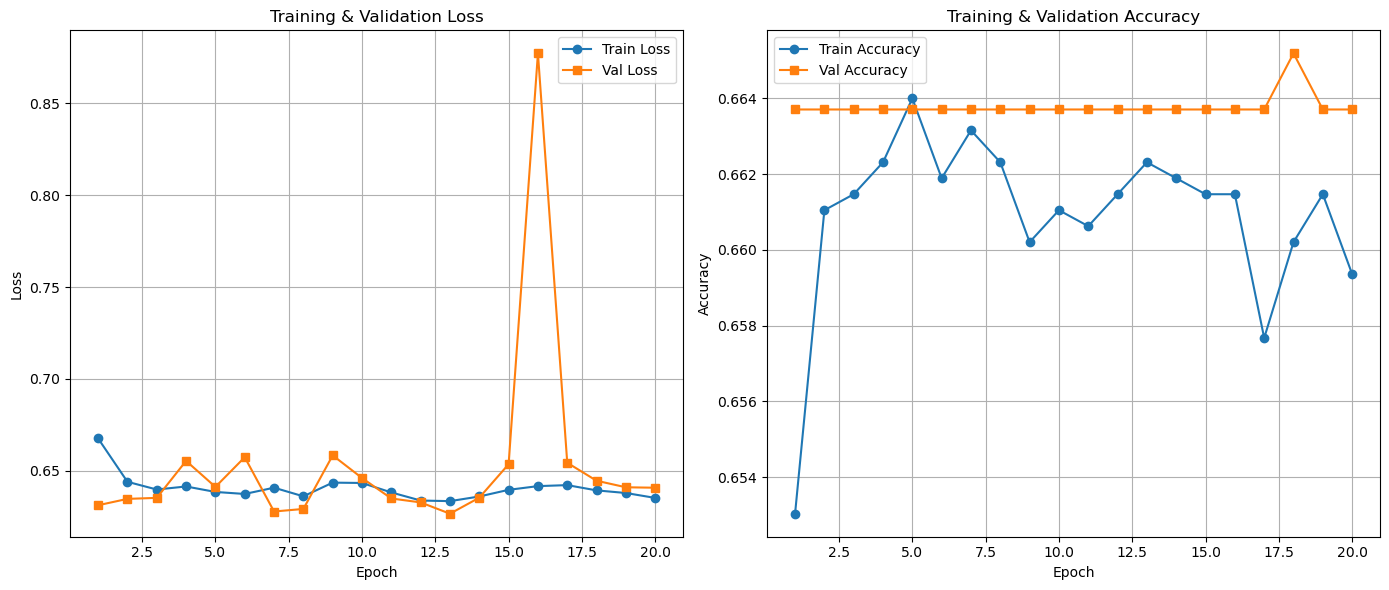

Training Progress: 100%|██████████| 20/20 [11:54<00:00, 35.73s/epoch, loss=0.635, train_acc=0.659, val_acc=0.664, val_loss=0.641]


In [ ]:
# エポック数（学習全体を繰り返す回数）の設定
# 過学習を見たい方はエポック数を50にしてみてください。25エポック目から綺麗な過学習が観測出来ます。
num_epochs = 25

# 学習の経過を記録するためのリスト（後でグラフ化などに使用）
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# デバイス（CPUまたはGPU）の設定
# GPUが使える環境ならGPUを使い、そうでなければCPUを使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# tqdmを用いて、エポック単位で進捗（学習状況）を表示する
# descには説明文、unitには単位（ここでは"epoch"）を指定
epoch_bar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch")

for epoch in epoch_bar:
    epoch_num = epoch + 1  # 人間が分かりやすいように1から数える
    # モデルを訓練モードに切り替える（ドロップアウトやバッチ正規化が訓練用の挙動になる）
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # 訓練データ（train_loader）でモデルを学習
    # 各バッチ（小分けしたデータ単位）ごとに処理する
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # BCE系の損失関数を使う場合は、ラベルを[batch_size, 1]の形にし、float型にする
        labels = labels.view(-1, 1).float()

        # 前のバッチで計算された勾配をリセット
        optimizer.zero_grad()

        # 順伝播：モデルに入力を与えて予測値（outputs）を取得
        outputs = model(inputs)

        # 損失（誤差）を計算
        loss = criterion(outputs, labels)

        # 逆伝播：損失をもとにモデルのパラメータを更新するための勾配を計算
        loss.backward()

        # パラメータを更新（重み調整）
        optimizer.step()

        # バッチごとの損失を累積
        running_loss += loss.item() * inputs.size(0)

        # 出力（outputs）が0.5以上ならクラス1、そうでなければクラス0と判断
        probs = torch.sigmoid(outputs)
        preds = (outputs >= 0.3).float()
        # 正解数をカウント
        correct += (preds == labels).sum().item()
        # 全サンプル数をカウント
        total += labels.size(0)

    # 1エポックが終了した時点での平均損失と正解率
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # モデルを評価モードに変更（ドロップアウトやバッチ正規化が推論用の挙動になる）
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    # 検証データ（val_loader）でモデルの性能を確認（勾配計算なし）
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # ラベルを[batch_size, 1]、float型に整形
            labels = labels.view(-1, 1).float()

            # 順伝播のみ実行（重みは更新しない）
            outputs = model(inputs)
            # 検証用の損失計算
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs)
            preds = (outputs >= 0.6).float()  # HINT:ここの閾値は大事です。ほんとに0.5で良いのでしょうか…？
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # 検証データでの平均損失と正解率
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # tqdmの表示欄に、現在のエポックでの訓練損失、訓練精度、検証損失、検証精度を表示
    epoch_bar.set_postfix(loss=epoch_loss, train_acc=epoch_acc, val_loss=val_epoch_loss, val_acc=val_epoch_acc)

    # ここを追加：エポックごとにplot_metricsを呼び出してグラフ更新
    # 学習と検証のLoss/Accuracyの推移をリアルタイムに表示
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, window=5)



## モデルの保存

In [104]:
# 保存先ディレクトリの作成
output_dir = r"D:\puresotu\workespace\nakayama_ken-main\nakayama_ken-main\result"
os.makedirs(output_dir, exist_ok=True)

# 重み保存用のフォルダ作成
weight_dir = os.path.join(output_dir, 'Weight')
os.makedirs(weight_dir, exist_ok=True)

In [105]:
# モデルの保存
torch.save(model.state_dict(), f'{weight_dir}/breast_cancer_model.pth') #作成するファイル名を確認 適時変更してください。


# 検証データの確認

In [106]:
# モデルの重みが保存されているディレクトリとファイル名を指定
weight_path = os.path.join(weight_dir, 'breast_cancer_model.pth')

# 保存した重みをロード
model.load_state_dict(torch.load(weight_path))
model.eval()

all_preds = []
all_labels = []
all_probs = []  # ROC曲線用に確率値を保存（outputsのsigmoid後）

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()
        
        # モデルによる予測
        outputs = model(inputs)

        # outputsはシグモイド後の場合は確率、Sigmoidなしならsigmoidを適用
        # もしモデルでSigmoidを最後にかけていないなら:
        # probs_tensor = torch.sigmoid(outputs)
        # 今回はモデルでSigmoidをかけていると仮定:
        probs_tensor = outputs
        
        # 確率値をCPUへ移し、NumPyへ
        probs = probs_tensor.cpu().numpy().flatten()
        all_probs.extend(probs)

        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# NumPy配列に変換
y_true = np.array(all_labels).flatten()
y_pred = np.array(all_preds).flatten()

# 混合行列、Accuracy、AUCなどの計算
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

# 混合行列を分解し、感度(Recall), 特異度(Specificity)を計算
# cm = [[TN, FP],
#       [FN, TP]]
TN, FP, FN, TP = cm.ravel()
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Accuracy:", acc)
print("AUC:", auc)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

Accuracy: 0.6637037037037037
AUC: 0.5
Sensitivity (Recall): 0.0
Specificity: 1.0


## 混合行列の可視化

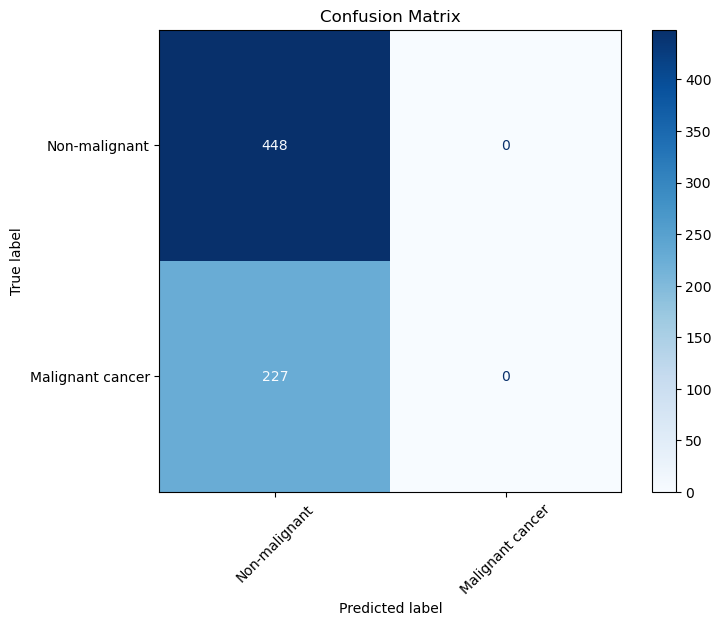

In [107]:
# 混合行列の可視化
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-malignant', 'Malignant cancer'])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

上記の混合行列を確認すると全然だめですね。。。。

## ROC曲線を描画

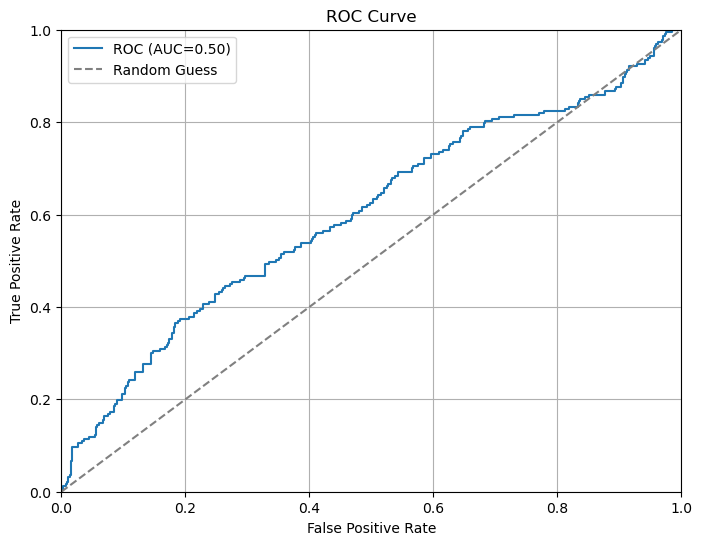

In [108]:
# ROC曲線を描画
# all_probsにはクラス1（Malignant cancer）の確率が入っていると想定
fpr, tpr, thresholds = roc_curve(y_true, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray', label='Random Guess')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend()

# モデルの評価

テストデータを使用してモデルの性能を評価します。

In [109]:
from tqdm import tqdm  

# 推論用データセットクラス
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # ディレクトリ内の全ての画像ファイルを取得
        self.image_files = [f for f in os.listdir(root_dir) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_file)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_file

test_dataset = TestDataset(root_dir=test_dir, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model.eval()

predictions = []  # (image_id, pred_label)を格納するリスト
with torch.no_grad():
    for images, filenames in tqdm(test_loader, desc="Test Prediction"):
        images = images.to(device)
        outputs = model(images)
        preds = (outputs.squeeze() >= 0.6).float().cpu().numpy().astype(int) # HINT:ここの閾値は大事です。

        for fn, p in zip(filenames, preds):
            # 拡張子を削除
            image_id = os.path.splitext(fn)[0]
            predictions.append((image_id, p))

Test Prediction: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


# 提出用ファイル作成

提出用ファイルを作成します。<br/>
ファイル名は、都合が良いように変更してください。

In [ ]:
# 提出用のフォルダ作成
prediction_dir = os.path.join(output_dir, 'Prediction') #名前を変えておく
os.makedirs(prediction_dir, exist_ok=True)

# 推論結果をCSVファイルとして出力する
submit_file_path = f'{prediction_dir}/sample_submit7.csv' #作成するファイル名を確認 適時変更してください。
df = pd.DataFrame(predictions, columns=['image_id', 'label'])
df.to_csv(submit_file_path, index=False)

print(f"サブミットファイルが {submit_file_path} に作成されました。")
df.head()

サブミットファイルが D:\puresotu\workespace\nakayama_ken-main\nakayama_ken-main\result\Prediction/sample_submit6.csv に作成されました。


,image_id,label
0,00242,0
1,00423,0
2,01146,0
3,01160,0
4,02334,0
